In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
#needed to import qke procedures
import sys
from pathlib import Path
import numpy as np
from qiskit_algorithms.utils import algorithm_globals

main_dir = str(Path().resolve().parent)
sys.path.insert(1, main_dir)

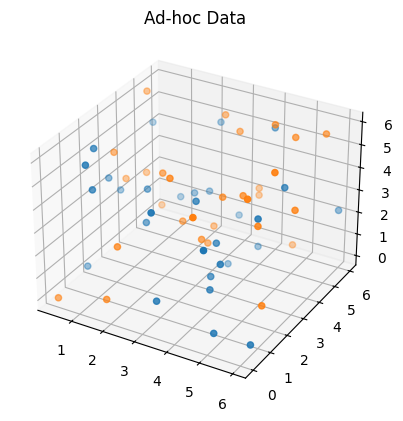

In [6]:
#load data ad hoc

#set the seed(s)
np.random.seed(123)
algorithm_globals.random_seed = 123

from qiskit_machine_learning.datasets import ad_hoc_data

adhoc_dimension = 3
X_train, y_train, X_test, y_test, adhoc_total = ad_hoc_data(
    training_size=30,
    test_size=5,
    n=adhoc_dimension,
    gap=0.3,
    plot_data=True,
    one_hot=False,
    include_sample_total=True,
)

In [7]:
max_iter = 20
NUM_QBIT = X_train.shape[1] # nqubit = nuber of dimension (feature)

#check the shape of test> and training dataset
print(f'Max number of iteration used in kernel optimization: {max_iter}')
print(f'Training shape dataset {X_train.shape}')
print(f'Label for traing {y_train.shape}')
print(f'Test shape dataset {X_test.shape}')
print(f'Label for test {y_test.shape}')
print(f'NUM_QUBIT {NUM_QBIT}')

Max number of iteration used in kernel optimization: 20
Training shape dataset (60, 3)
Label for traing (60,)
Test shape dataset (10, 3)
Label for test (10,)
NUM_QUBIT 3


In [11]:
#define the callback
from pqk.QKCallback import QKCallback
my_callback = QKCallback()

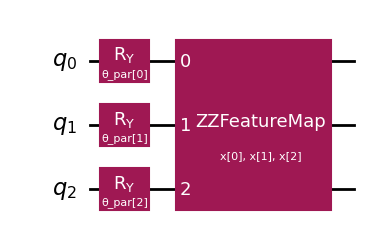

In [13]:
#get the feature mao
from pqk.TrainableCircuits import TrainableCircuits

qc_trainable = TrainableCircuits.zzfm(n_wire=NUM_QBIT)

fm = qc_trainable.qc
training_params = qc_trainable.training_parameters


fm.draw('mpl')

In [14]:
#define the trainable kernel
from pqk.CKernels import CKernels
from pqk.QMeasures import QMeasures
from pqk.TrainableKernelFeatureMap import TrainableKernelFeatureMap
from qiskit_machine_learning.kernels import TrainableFidelityQuantumKernel
from qiskit_algorithms.optimizers import SPSA
from qiskit_machine_learning.utils.loss_functions import SVCLoss

my_obs = ['ZII', 'IZI','IIZ']
nshots = 100 #paramenter using primitive estimator
measure_fn = QMeasures.StateVectorEstimator
kernel = CKernels.linear

#using kernel feature map (change the q_kernel in order to modiy the trainable kernel)
q_kernel = TrainableKernelFeatureMap(feature_map=fm, training_parameters=training_params)
q_kernel.configure(save_feature_map=False, obs=my_obs, nshots=nshots, q_measure=QMeasures.StateVectorEstimator, c_kernel=CKernels.rbf)

#q_kernel = TrainableFidelityQuantumKernel(feature_map=fm, training_parameters=training_params)

#define updater, loss and inizial param
spsa_opt = SPSA(maxiter=max_iter, learning_rate=0.03, perturbation=0.01, termination_checker=my_callback.callback)
loss_func = SVCLoss(C=1.0)
#init_point=[np.pi / 2 for _ in range(NUM_QBIT)] 
init_point = np.random.uniform(size=NUM_QBIT)

#print this info
#print(f'The QMeasure function used: {q_kernel.q_measure.__name__}')
#print(f'The classical kernel used: {q_kernel.kernel.__name__}')
print(f'The observables we use: {my_obs}')
print(f'The numbers of shots (if applicable) for (qiskit) primitive estimator: {nshots}')
print(f'Initial point: {init_point}')


The observables we use: ['ZII', 'IZI', 'IIZ']
The numbers of shots (if applicable) for (qiskit) primitive estimator: 100
Initial point: [0.69646919 0.28613933 0.22685145]


In [15]:
#******* Trainaing the kernel
#get time
import time
from sklearn.metrics import accuracy_score
from qiskit_machine_learning.kernels.algorithms.quantum_kernel_trainer import QuantumKernelTrainer


training_kernel_start = time.time()

qk_trainer = QuantumKernelTrainer(quantum_kernel=q_kernel, loss=loss_func, initial_point= init_point, optimizer=spsa_opt)
qkt_results = qk_trainer.fit(X_train, y_train)
optimized_kernel = qkt_results.quantum_kernel

training_kernel_end = time.time()

print(f'Time kernel training: {training_kernel_end - training_kernel_start} seconds.')



**********************
Print callback. Iteration 1
Number of function evaluations: 2
The paramenters: [0.71504123 0.30471138 0.2454235 ]
The function value: 50.060597301231354
The stepsize: 0.03216772028011415
Whether the step was accepted: True
**********************
**********************
Print callback. Iteration 2
Number of function evaluations: 4
The paramenters: [0.7158807  0.30387191 0.24626296]
The function value: 50.047174601922904
The stepsize: 0.0014540013541493673
Whether the step was accepted: True
**********************
**********************
Print callback. Iteration 3
Number of function evaluations: 6
The paramenters: [0.43920842 0.58054418 0.52293524]
The function value: 50.050394083243404
The stepsize: 0.4792104353593729
Whether the step was accepted: True
**********************
**********************
Print callback. Iteration 4
Number of function evaluations: 8
The paramenters: [0.30806074 0.71169186 0.65408292]
The function value: 48.263972705762974
The stepsize: 0.

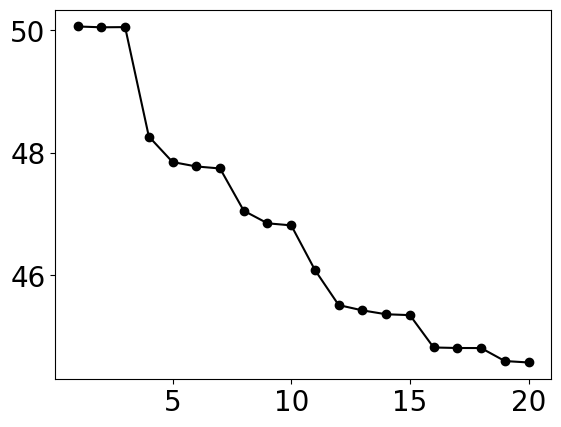

In [16]:
#plot data
my_callback.plot_data()

In [17]:
#TRAINING SVC
#using optimezed kernel in QSVC
from qiskit_machine_learning.algorithms.classifiers import QSVC

qsvc = QSVC(quantum_kernel=optimized_kernel)

#get time
training_svm_start = time.time()

qsvc.fit(X_train, y_train)

#get time training
training_svm_end = time.time()

#result...
predictions = qsvc.predict(X_test)
score = accuracy_score(predictions, y_test)

#final time (trainign + predict)
jobs_final_time = time.time()

print(f'*******SCORE: {score}')
print(f'Time training SVM: {training_svm_end - training_svm_start} seconds.')
print(f'Total jobs time: {jobs_final_time - training_kernel_start} seconds.')

*******SCORE: 0.7
Time training SVM: 0.6369941234588623 seconds.
Total jobs time: 66.2071328163147 seconds.
